In [1]:
import os
os.environ["SPS_HOME"] = "/Users/fpetri/packages/fsps" 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import lbg_forecast.sps as sps
import lbg_forecast.sfh as sfh
import lbg_forecast.priors as pr
import lbg_forecast.hyperparameters as hyp
import lbg_forecast.population_model as pop
import lbg_forecast.zhistory as zh
import lbg_forecast.priors as pr
from astropy.cosmology import WMAP9 as cosmo
from scipy.stats import truncnorm

In [3]:
#sps_model = sps.initialise_sps_model(neb_em=False)

In [4]:
#redshift_mass_prior_parameters = pr.setup_redshift_and_mass_priors(z_max=15)
#sps_parameters = pop.generate_sps_parameters(100, redshift_mass_prior_parameters)
hyperparameter_mu_bounds, hyperparameter_sigma_max = hyp.default_hyperparameter_bounds()

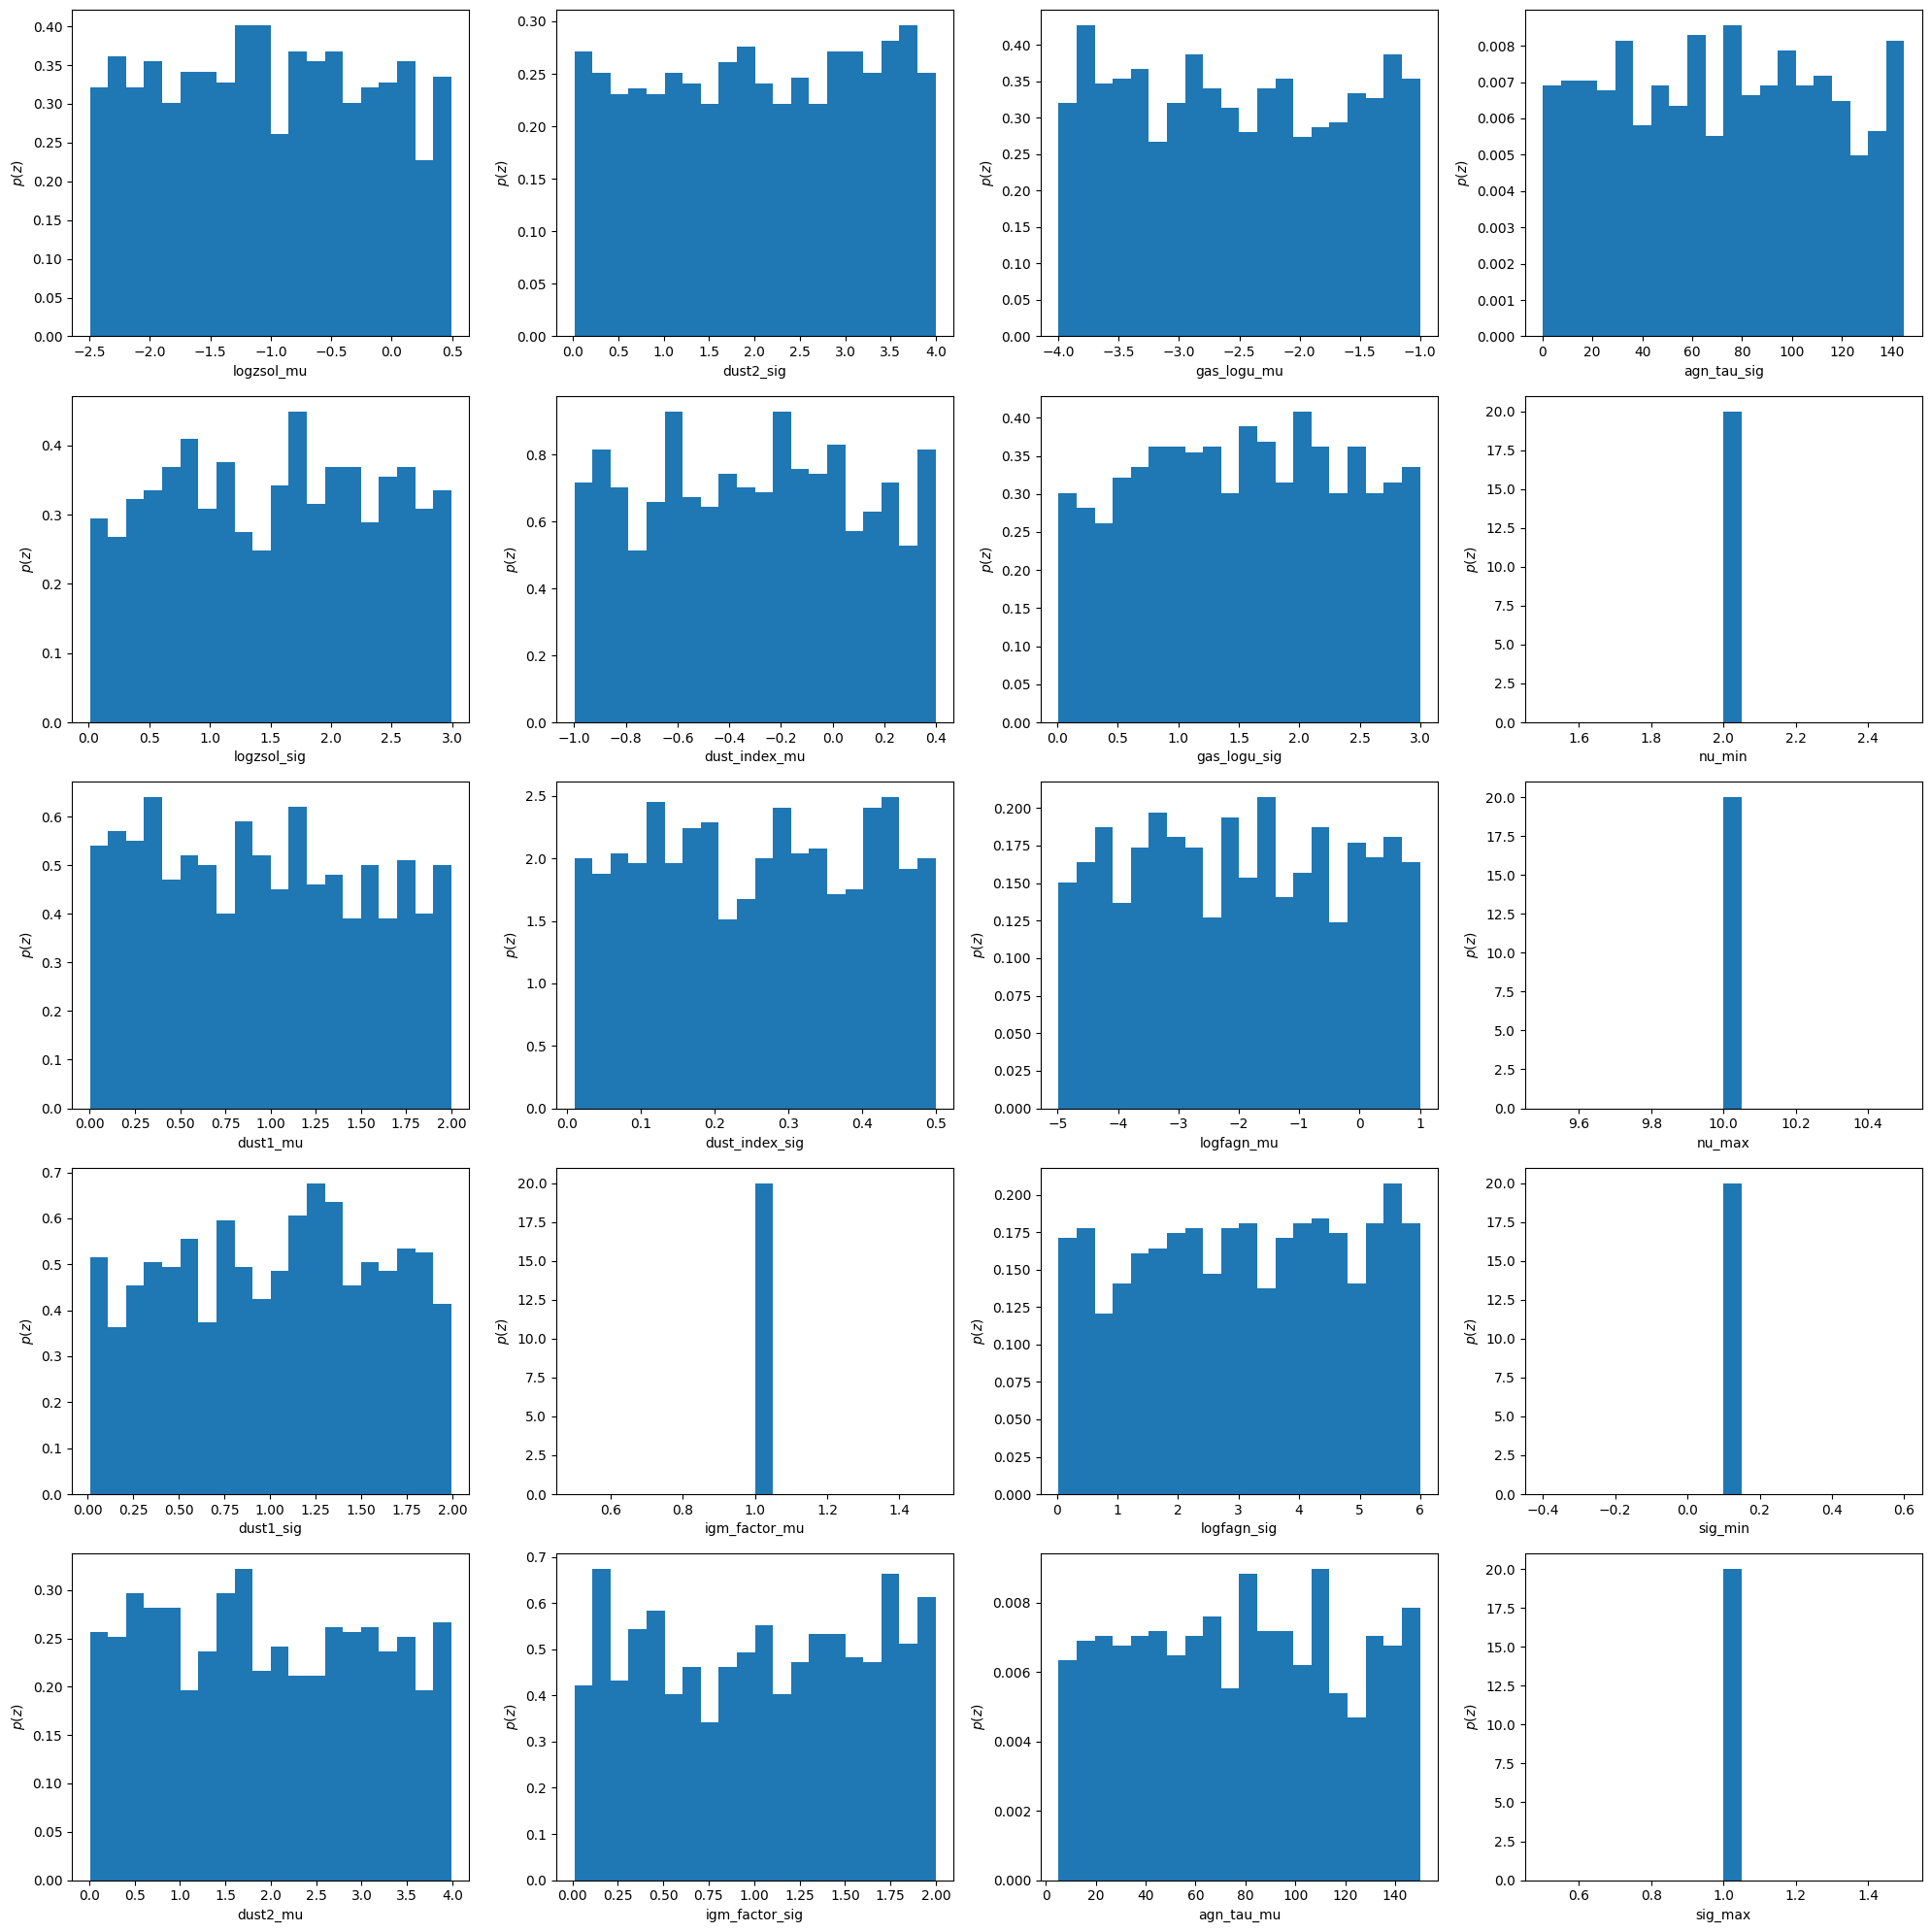

In [5]:
prior_parameters = hyp.sample_prior_parameters(1000, hyperparameter_mu_bounds, hyperparameter_sigma_max)
hyp._plot_hyperparameters(prior_parameters)